In [51]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

# Atrator de Lorenz
$$\frac{dx}{dt} = \sigma(y-x)$$
$$\frac{dy}{dt} = -xz + rx - y$$
$$\frac{dz}{dt} = xy - bz$$

In [52]:
def lor_rhs(x_y_z,t,sigma,b,r): #Equações do sistema que define atrator de Lorenz.
    x,y,z = x_y_z;
    dxdt = sigma*(-x+y)
    dydt = -x*z+r*x-y
    dzdt = x*y-b*z;
    return dxdt,dydt,dzdt

def plot_lor(sol,fig): #Função que plota a solução do sistema que define o atrator de Lorenz.
    x_true = sol[:,0]
    y_true = sol[:,1]
    z_true = sol[:,2]
    ax = fig.gca(projection='3d')
    ax.plot(x_true,y_true,z_true)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")
    #fig.set_size_inches(15,15)
    

Parametros das Equações de Lorenz, Ponto Inicial e Intervalo de Tempo

In [53]:
sigma = 10
b = 8/3
r = 28
x0 = [5, 5, 5] #Tem um erro associado.
t = np.arange(0,20+0.00001,0.01)

# Solução do Sistema

In [54]:
sol_true = odeint(lor_rhs, x0, t, args = (sigma,b,r))
# sol_true = solve_ivp(lambda t, xyz: lor_rhs(xyz, t, sigma, b, r), (0, 20), x0, method = "RK45", dense_output=False, max_step = 0.01).y.T
x_true = sol_true[:,0]
y_true = sol_true[:,1]
z_true = sol_true[:,2]


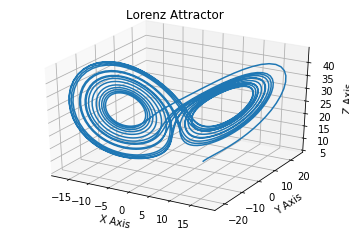

In [55]:
fig = plt.figure()
plot_lor(sol_true,fig)

## Variação das Condições Iniciais
Vamos avaliar o efeito de ruído nas condições iniciais. Para isso, tomaremos a condição inicial utilizada para solução do problema acima e somaremos um termo de erro gerado aleatóriamente (multiplicado por uma constante sigma2 que diz respeito à força/variância desse erro).

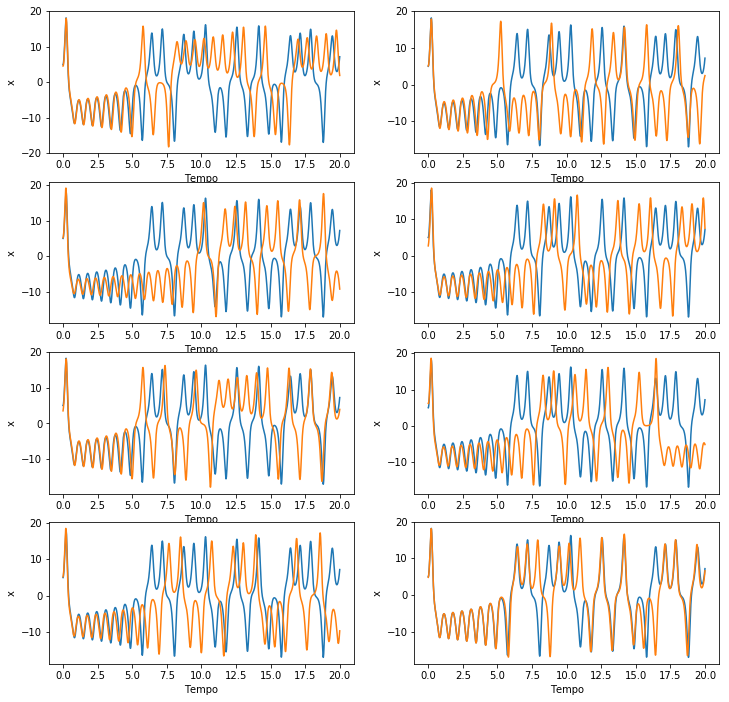

In [56]:
sigma2 = 1; #Strengh of noise in initial condition (variance of q2)

fig = plt.figure()

for i in range(1,9):
    xic = x0 + sigma2*np.random.randn(3) #np.random.randn gera v.a. normal padrão. 
    sol = odeint(lor_rhs, xic, t, args = (sigma,b,r)) #Resolve a equação com essa condição inicial.
    #Plota a Componente X da solução com condição perturbada em comparação com a solução original.
    ax = plt.subplot(4,2,i)
    ax.plot(t,x_true,t,sol[:,0])
    ax.set_xlabel('Tempo')
    ax.set_ylabel('x')
fig.set_size_inches(12,12)
#fig.suptitle('Trajetória de x para diversas perturbações nas condições iniciais');

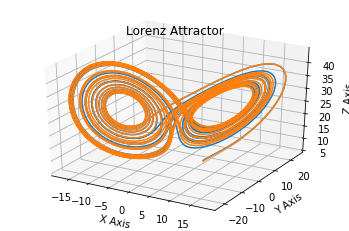

In [57]:
fig2 = plt.figure()
plot_lor(sol,fig2)
plot_lor(sol_true,fig2)

# Observações (Considerando ruído de sensores)
Vamos considerar que medidas são feitas com passo 0.5 de tempo e que essas observações são dados pelos valores reais somados de um erro (q3).

In [58]:
tdata = t[::50]#Apenas em alguns tempos considerados para a solução do sistema teremos observações (a cada 0.5)
n = len(tdata) #Número de Observações.

#Geração dos Ruídos que determinarão as observações.
xn = np.random.randn(n) 
yn = np.random.randn(n)
zn = np.random.randn(n)
sigma3 = 1#error strengh

#Observações
xdata = x_true[::50] + sigma3*xn
ydata = y_true[::50] + sigma3*yn
zdata = z_true[::50] + sigma3*zn

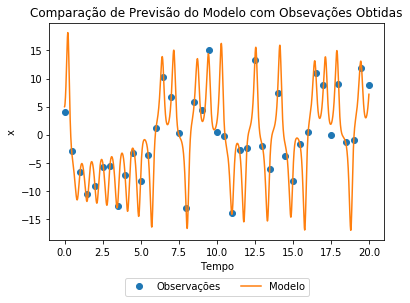

In [59]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(tdata,xdata,'o',label = 'Observações');
ax.plot(t,x_true,label = 'Modelo');
ax.set_xlabel('Tempo')
ax.set_ylabel('x')
ax.set_title('Comparação de Previsão do Modelo com Obsevações Obtidas');
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2);
#fig.set_size_inches(10,8)

Em laranja temos os dados reais, do modelo (solução do sistema de equações diferenciais). Em azul temos resultados experimentais, que estão atrelados a erros e, portanto, não coincidem com o modelo. A assimilação de dados buscará integrar os resultados do modelo e os resultados experimentais.

# Assimilação de Dados

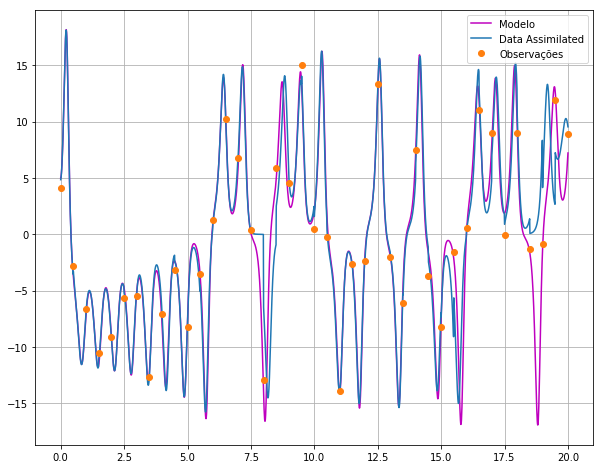

In [60]:
da_sol = [] # data assimilated solution. Ou seja, solução após técnica de assimilação de dados.
for i in range(0,len(tdata)-1): #len(tdata) é o número de medidas que temos. Em t = 0 conhecemos o valor pela c.i.    
    
    #Passo no tempo para a assimilação será 0.5. Nesse intervalo tspan será usado para ode.    
    tspan = np.arange(0,0.51,0.01) 
    
#     sol = solve_ivp(lambda t, xyz: lor_rhs(xyz, t, sigma, b, r), tspan, xic, method = "LSODA", dense_output=True)
    sol = odeint(lor_rhs, xic, tspan, args = (sigma,b,r))
    #Último ponto da solução agora é condição inicial para o próximo passo.
    xic0 = sol[-1,:] # posições x,y,z após dar um passo no tempo de 0.5
    
    #xdata já esta definido em intervalos de 0.5. Para cada passo i, consideramos i-ésima observação.
    xdat = np.asarray([xdata[i+1], ydata[i+1],zdata[i+1]])
    
    K = sigma2/(sigma2 +sigma3)
    xic = xic0 + K * (xdat - xic0)
    
    #Acrescenta na array da_sol a solução obtida para este passo.
    #Considera até penultimo elemento, pois último será utilizado como condição inicial para o próximo passo.
    da_sol.append(sol[0:-1,:])

# da_sol = np.vstack(da_sol) # concatena lista sem adicionar ultimo elemento
da_sol = np.vstack([*da_sol, sol[-1]]) # concatena lista de matrizes e adiciona ultimo elemento

#Plota a Componente X da Solução pós assimilação de dados e da Solução Verdadeira (modelo).
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(t,x_true,'m',label = 'Modelo')
ax.plot(t,da_sol[0:,0],label = 'Data Assimilated')
ax.plot(tdata,xdata,'o',label = 'Observações');
fig.set_size_inches(10,8)
ax.legend()
ax.grid()

In [61]:
# da_sol = np.array([[0,0,0]])#data assimilated solution. Ou seja, solução após técnica de assimilação de dados.
# for i in range(0,len(tdata)): #len(tdata) é o número de medidas que temos. Em t = 0 conhecemos o valor pela c.i.    
    
#     #Passo no tempo para a assimilação será 0.5. Nesse intervalo tspan será usado para ode.    
#     tspan = np.arange(0,0.51,0.01) 
    
#     sol = odeint(lor_rhs, xic, tspan, args = (sigma,b,r))
    
#     #Último ponto da solução agora é condição inicial para o próximo passo.
#     xic0 = [sol[-1,0],sol[-1,1], sol[-1,2]] #posições x,y,z após dar um passo no tempo de 0.5
    
#     #xdata já esta definido em intervalos de 0.5. Para cada passo i, consideramos i-ésima observação.
#     xdat = [xdata[i], ydata[i],zdata[i]]
    
#     #xic = xic0 + (K*(xdat-xic0))
#     K = sigma2/(sigma2 +sigma3)
#     aux = [K*(a - b) for a, b in zip(xdat, xic0)]
#     xic = [a + b for a, b in zip(xic0, aux)]
    
#     #Acrescenta na array da_sol a solução obtida para este passo.
#     #Considera até penultimo elemento, pois último será utilizado como condição inicial para o próximo passo.
#     da_sol = np.concatenate((da_sol, sol[0:-1,:]),axis = 0)

# a = np.array([list(sol[-1,:])])
# #da_sol = np.concatenate((da_sol, a),axis = 0) #Acrescenta o último elemento. (Seria utilizado como c.i. para prox passo)

# #Plota a Componente X da Solução pós assimilação de dados e da Solução Verdadeira (modelo).
# fig = plt.figure()
# ax = plt.subplot(111)
# ax.plot(t,x_true,'m',label = 'Modelo')
# ax.plot(t,da_sol[1:,0],label = 'Data Assimilated')
# ax.plot(tdata,xdata,'o',label = 'Observações');
# fig.set_size_inches(10,8)
# ax.legend()
# ax.grid()